In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
def load_data(path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.CenterCrop(224)
    ])

    dataset = ImageFolder(path, transform=transform)

    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)
    val_size = int(0.15 * dataset_size)
    test_size = dataset_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [10]:
def imshow_grid(batch, labels):
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))

    for i in range(16):
        image = batch[i].permute(1, 2, 0).numpy()
        label = labels[i]

        ax = axes[i // 4, i % 4]
        ax.imshow(image)
        ax.set_title(f"{label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

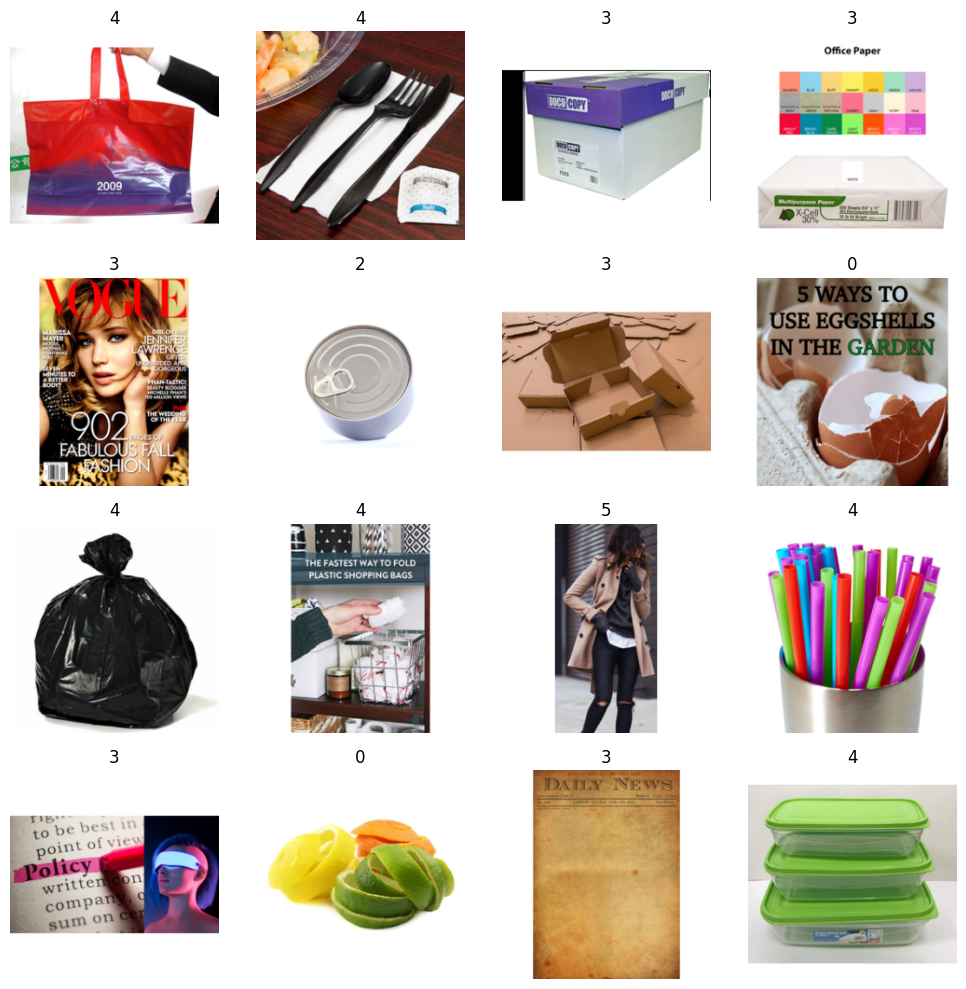

In [11]:
path = r'C:\Users\Nickv\Documents\ImageProcessing\Project\dataset\images'
class_names = [f'{name}' for name in os.listdir(path)]
train_loader, val_loader, test_loader = load_data(path)
batch, labels = next(iter(train_loader))
imshow_grid(batch, labels)

In [12]:
class Resnet50(nn.Module):
    def __init__(self, num_classes=6):
        super(Resnet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        num_features = list(self.resnet50.children())[-1].in_features
        self.resnet50 = nn.Sequential(*list(self.resnet50.children())[:-1],
                                      nn.Flatten(),
                                      nn.Linear(num_features, num_classes)
                                      )

    def forward(self, x):
        x = self.resnet50(x)
        return x

In [26]:
class MobileNetV3(nn.Module):
    def __init__(self, num_classes=6):
        super(MobileNetV3, self).__init__()
        self.mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)

        self.mobilenet_v3 = nn.Sequential(*list(self.mobilenet_v3.children())[:-1],
                                      nn.Flatten(),
                                      nn.Linear(960, num_classes)
                                      )
    
    def forward(self, x):
        x = self.mobilenet_v3(x)
        return x

In [18]:
def train(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cuda'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0.0
        step = 0
        correct_train = 0
        total_train = 0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        
        for images, labels in train_bar:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            avg_train_loss += loss.item()
            _,predicted = torch.max(outputs,1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            step += 1

            train_bar.set_postfix(loss=loss.item())

        avg_train_loss /= step
        train_accuracy = 100 * correct_train/total_train
        
        model.eval()
        avg_val_loss = 0.0
        correct_val = 0
        total_val = 0
        val_bar = tqdm(val_loader, desc='📄 Validation', unit='batch')
            
        with torch.no_grad():
            for images, labels in val_bar:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                val_loss = loss_fn(outputs, labels)

                avg_val_loss += val_loss.item()
                _,predicted = torch.max(outputs,1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val/total_val
    
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f},Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        if writer:
            writer.add_scalar('Accuracy/Train', train_accuracy, epoch + 1)
            writer.add_scalar('Loss/Train', avg_train_loss, epoch + 1)
            writer.add_scalar('Accuracy/Validation', val_accuracy, epoch + 1)
            writer.add_scalar('Loss/Validation', avg_val_loss, epoch + 1)

        if checkpoint_path:
            torch.save(model.state_dict(), f"{checkpoint_path}_epoch_{epoch+1}.pth")

    print("🏁 Training completed.")


def evaluate_task(y_true, y_pred, target_names="Task"):
    clf_report = classification_report(y_true, y_pred, target_names=target_names, zero_division=1)
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("\nClassification Report:\n", clf_report)

    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = conf_matrix.max() / 2.
    for i, j in np.ndindex(conf_matrix.shape):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    plt.tight_layout()
    plt.show()

In [29]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

model1 = Resnet50()


writer = SummaryWriter(log_dir='./runs/resnet_experiment')
opt = optim.Adam(model1.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model=model1, opt=opt, loss_fn=loss_fn, epochs=50, train_loader=train_loader, val_loader=val_loader, writer=writer, device='cuda', checkpoint_path="models/model1/model1")
writer.close()

c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


📄 Validation: 100%|██████████| 141/141 [00:22<00:00,  6.37batch/s]


Epoch [1/50], Train Loss: 1.2848, Train Acc: 54.2762,Val Loss: 3.6069, Val Acc: 28.2667


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.29batch/s]


Epoch [2/50], Train Loss: 0.9703, Train Acc: 65.7048,Val Loss: 1.1120, Val Acc: 60.8889


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.21batch/s]


Epoch [3/50], Train Loss: 0.8175, Train Acc: 71.3714,Val Loss: 1.5889, Val Acc: 45.6000


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.21batch/s]


Epoch [4/50], Train Loss: 0.6858, Train Acc: 76.0476,Val Loss: 0.7286, Val Acc: 75.6444


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.12batch/s]


Epoch [5/50], Train Loss: 0.5924, Train Acc: 79.4762,Val Loss: 2.4736, Val Acc: 47.5111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.13batch/s]


Epoch [6/50], Train Loss: 0.5168, Train Acc: 82.3048,Val Loss: 0.6784, Val Acc: 76.7111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.22batch/s]


Epoch [7/50], Train Loss: 0.4352, Train Acc: 85.0571,Val Loss: 1.5420, Val Acc: 60.2667


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.13batch/s]


Epoch [8/50], Train Loss: 0.3613, Train Acc: 87.6857,Val Loss: 0.7822, Val Acc: 73.6889


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.10batch/s]


Epoch [9/50], Train Loss: 0.2998, Train Acc: 89.5143,Val Loss: 0.7446, Val Acc: 78.2667


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.15batch/s]


Epoch [10/50], Train Loss: 0.2428, Train Acc: 91.8095,Val Loss: 0.6258, Val Acc: 82.9778


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.16batch/s]


Epoch [11/50], Train Loss: 0.2216, Train Acc: 92.5810,Val Loss: 0.6078, Val Acc: 82.9778


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.57batch/s]


Epoch [12/50], Train Loss: 0.1772, Train Acc: 94.1524,Val Loss: 0.8140, Val Acc: 78.0444


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.57batch/s]


Epoch [13/50], Train Loss: 0.1589, Train Acc: 94.6571,Val Loss: 0.8070, Val Acc: 80.0889


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.48batch/s]


Epoch [14/50], Train Loss: 0.1526, Train Acc: 94.9048,Val Loss: 0.5688, Val Acc: 85.5111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.66batch/s]


Epoch [15/50], Train Loss: 0.1154, Train Acc: 96.1238,Val Loss: 0.8800, Val Acc: 76.8000


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.59batch/s]


Epoch [16/50], Train Loss: 0.1260, Train Acc: 96.0762,Val Loss: 0.6756, Val Acc: 83.2000


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.50batch/s]


Epoch [17/50], Train Loss: 0.1144, Train Acc: 96.2762,Val Loss: 0.6787, Val Acc: 83.5111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.60batch/s]


Epoch [18/50], Train Loss: 0.0992, Train Acc: 96.9333,Val Loss: 0.8608, Val Acc: 79.5111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.51batch/s]


Epoch [19/50], Train Loss: 0.0867, Train Acc: 97.4381,Val Loss: 0.8555, Val Acc: 80.9333


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.57batch/s]


Epoch [20/50], Train Loss: 0.1114, Train Acc: 96.4000,Val Loss: 0.8730, Val Acc: 80.0444


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.54batch/s]


Epoch [21/50], Train Loss: 0.1031, Train Acc: 96.7048,Val Loss: 0.6286, Val Acc: 85.9111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.51batch/s]


Epoch [22/50], Train Loss: 0.0686, Train Acc: 97.9905,Val Loss: 0.8482, Val Acc: 82.2667


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.56batch/s]


Epoch [23/50], Train Loss: 0.0874, Train Acc: 97.0667,Val Loss: 0.8341, Val Acc: 81.5111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.56batch/s]


Epoch [24/50], Train Loss: 0.0793, Train Acc: 97.2762,Val Loss: 0.8535, Val Acc: 81.7333


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.59batch/s]


Epoch [25/50], Train Loss: 0.0734, Train Acc: 97.7143,Val Loss: 0.7167, Val Acc: 84.1333


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.55batch/s]


Epoch [26/50], Train Loss: 0.0673, Train Acc: 97.8476,Val Loss: 0.8319, Val Acc: 83.9111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.57batch/s]


Epoch [27/50], Train Loss: 0.0730, Train Acc: 97.6286,Val Loss: 0.7748, Val Acc: 84.2667


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.52batch/s]


Epoch [28/50], Train Loss: 0.0539, Train Acc: 98.3238,Val Loss: 1.0119, Val Acc: 81.4222


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.60batch/s]


Epoch [29/50], Train Loss: 0.0733, Train Acc: 97.6381,Val Loss: 1.0848, Val Acc: 79.5556


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.60batch/s]


Epoch [30/50], Train Loss: 0.0680, Train Acc: 97.7333,Val Loss: 0.6700, Val Acc: 85.9556


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.60batch/s]


Epoch [31/50], Train Loss: 0.0628, Train Acc: 98.2000,Val Loss: 0.7492, Val Acc: 85.2889


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.61batch/s]


Epoch [32/50], Train Loss: 0.0680, Train Acc: 97.7619,Val Loss: 0.7986, Val Acc: 84.3111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.56batch/s]


Epoch [33/50], Train Loss: 0.0371, Train Acc: 98.8286,Val Loss: 0.8971, Val Acc: 81.7333


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.51batch/s]


Epoch [34/50], Train Loss: 0.0584, Train Acc: 98.0667,Val Loss: 0.9302, Val Acc: 82.0000


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.57batch/s]


Epoch [35/50], Train Loss: 0.0602, Train Acc: 98.0381,Val Loss: 0.7255, Val Acc: 85.3778


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.58batch/s]


Epoch [36/50], Train Loss: 0.0459, Train Acc: 98.4190,Val Loss: 0.7903, Val Acc: 83.5111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.57batch/s]


Epoch [37/50], Train Loss: 0.0600, Train Acc: 98.0476,Val Loss: 0.8183, Val Acc: 84.2222


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.60batch/s]


Epoch [38/50], Train Loss: 0.0445, Train Acc: 98.5714,Val Loss: 0.9155, Val Acc: 81.7778


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.55batch/s]


Epoch [39/50], Train Loss: 0.0528, Train Acc: 98.2571,Val Loss: 1.0769, Val Acc: 75.6889


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.51batch/s]


Epoch [40/50], Train Loss: 0.0347, Train Acc: 98.8952,Val Loss: 0.7566, Val Acc: 85.2000


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.55batch/s]


Epoch [41/50], Train Loss: 0.0573, Train Acc: 98.1048,Val Loss: 0.8140, Val Acc: 83.9111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.54batch/s]


Epoch [42/50], Train Loss: 0.0481, Train Acc: 98.6190,Val Loss: 0.8057, Val Acc: 85.8222


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.50batch/s]


Epoch [43/50], Train Loss: 0.0379, Train Acc: 98.7143,Val Loss: 0.7817, Val Acc: 85.7333


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.58batch/s]


Epoch [44/50], Train Loss: 0.0498, Train Acc: 98.3810,Val Loss: 1.0101, Val Acc: 82.1778


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.55batch/s]


Epoch [45/50], Train Loss: 0.0398, Train Acc: 98.8190,Val Loss: 0.7695, Val Acc: 83.5556


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.47batch/s]


Epoch [46/50], Train Loss: 0.0489, Train Acc: 98.3714,Val Loss: 0.8401, Val Acc: 82.0000


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.58batch/s]


Epoch [47/50], Train Loss: 0.0403, Train Acc: 98.6667,Val Loss: 0.9364, Val Acc: 81.0667


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.58batch/s]


Epoch [48/50], Train Loss: 0.0331, Train Acc: 98.7905,Val Loss: 1.1017, Val Acc: 78.8000


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.54batch/s]


Epoch [49/50], Train Loss: 0.0498, Train Acc: 98.3238,Val Loss: 0.8866, Val Acc: 85.1111


📄 Validation: 100%|██████████| 141/141 [00:10<00:00, 13.49batch/s]

Epoch [50/50], Train Loss: 0.0354, Train Acc: 98.7810,Val Loss: 1.0071, Val Acc: 81.7333
🏁 Training completed.


In [30]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

model2 = MobileNetV3()

writer = SummaryWriter(log_dir='./runs/mobilenet_experiment')
opt = optim.Adam(model2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model=model2, opt=opt, loss_fn=loss_fn, epochs=50, train_loader=train_loader, val_loader=val_loader, writer=writer, device='cuda', checkpoint_path="models/model2/model2")
writer.close()

c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.57batch/s]


Epoch [1/50], Train Loss: 0.6543, Train Acc: 77.2095,Val Loss: 0.5403, Val Acc: 81.2000


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.75batch/s]


Epoch [2/50], Train Loss: 0.4072, Train Acc: 85.8952,Val Loss: 0.5056, Val Acc: 83.0222


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.63batch/s]


Epoch [3/50], Train Loss: 0.3085, Train Acc: 89.5333,Val Loss: 0.4074, Val Acc: 86.3556


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.56batch/s]


Epoch [4/50], Train Loss: 0.2495, Train Acc: 91.5048,Val Loss: 0.3753, Val Acc: 87.0667


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.71batch/s]


Epoch [5/50], Train Loss: 0.2060, Train Acc: 92.9619,Val Loss: 0.4013, Val Acc: 87.2000


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.61batch/s]


Epoch [6/50], Train Loss: 0.1762, Train Acc: 94.2095,Val Loss: 0.4708, Val Acc: 87.9556


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.67batch/s]


Epoch [7/50], Train Loss: 0.1592, Train Acc: 94.6762,Val Loss: 0.6197, Val Acc: 84.4889


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.42batch/s]


Epoch [8/50], Train Loss: 0.1438, Train Acc: 94.9810,Val Loss: 0.5169, Val Acc: 88.0000


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.69batch/s]


Epoch [9/50], Train Loss: 0.1214, Train Acc: 96.1238,Val Loss: 0.4909, Val Acc: 86.8889


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.91batch/s]


Epoch [10/50], Train Loss: 0.1220, Train Acc: 95.9714,Val Loss: 0.4164, Val Acc: 88.6222


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.57batch/s]


Epoch [11/50], Train Loss: 0.1198, Train Acc: 96.2381,Val Loss: 0.5362, Val Acc: 86.8889


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.74batch/s]


Epoch [12/50], Train Loss: 0.0785, Train Acc: 97.6095,Val Loss: 0.4783, Val Acc: 87.4667


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.49batch/s]


Epoch [13/50], Train Loss: 0.1123, Train Acc: 96.4381,Val Loss: 0.5568, Val Acc: 87.6889


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.56batch/s]


Epoch [14/50], Train Loss: 0.1023, Train Acc: 96.6190,Val Loss: 0.3849, Val Acc: 89.9556


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.57batch/s]


Epoch [15/50], Train Loss: 0.0868, Train Acc: 97.1905,Val Loss: 0.4296, Val Acc: 89.7333


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.81batch/s]


Epoch [16/50], Train Loss: 0.0716, Train Acc: 97.5333,Val Loss: 0.5709, Val Acc: 88.3111


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.78batch/s]


Epoch [17/50], Train Loss: 0.0923, Train Acc: 96.8476,Val Loss: 0.4968, Val Acc: 87.6000


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.78batch/s]


Epoch [18/50], Train Loss: 0.0718, Train Acc: 97.6952,Val Loss: 0.4330, Val Acc: 90.9333


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.53batch/s]


Epoch [19/50], Train Loss: 0.1076, Train Acc: 96.4762,Val Loss: 0.4352, Val Acc: 90.1778


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 18.82batch/s]


Epoch [20/50], Train Loss: 0.0565, Train Acc: 98.1429,Val Loss: 0.4482, Val Acc: 90.0444


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.32batch/s]


Epoch [21/50], Train Loss: 0.0722, Train Acc: 97.6762,Val Loss: 0.5814, Val Acc: 87.0222


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.23batch/s]


Epoch [22/50], Train Loss: 0.0636, Train Acc: 97.8095,Val Loss: 0.4911, Val Acc: 89.2889


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.40batch/s]


Epoch [23/50], Train Loss: 0.0635, Train Acc: 97.8571,Val Loss: 0.4335, Val Acc: 89.7333


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.26batch/s]


Epoch [24/50], Train Loss: 0.0601, Train Acc: 98.0000,Val Loss: 0.5258, Val Acc: 88.7111


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.18batch/s]


Epoch [25/50], Train Loss: 0.0696, Train Acc: 97.5143,Val Loss: 0.5659, Val Acc: 87.9556


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 18.96batch/s]


Epoch [26/50], Train Loss: 0.0657, Train Acc: 97.8381,Val Loss: 0.5428, Val Acc: 89.0667


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.30batch/s]


Epoch [27/50], Train Loss: 0.0607, Train Acc: 98.1714,Val Loss: 0.4502, Val Acc: 90.2667


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.59batch/s]


Epoch [28/50], Train Loss: 0.0589, Train Acc: 98.0762,Val Loss: 0.4116, Val Acc: 91.2444


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.21batch/s]


Epoch [29/50], Train Loss: 0.0707, Train Acc: 97.4667,Val Loss: 0.5241, Val Acc: 88.7556


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.26batch/s]


Epoch [30/50], Train Loss: 0.0367, Train Acc: 98.7143,Val Loss: 0.4751, Val Acc: 89.5111


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 18.76batch/s]


Epoch [31/50], Train Loss: 0.0557, Train Acc: 98.2667,Val Loss: 0.4690, Val Acc: 88.4000


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.12batch/s]


Epoch [32/50], Train Loss: 0.0546, Train Acc: 98.3333,Val Loss: 0.6190, Val Acc: 88.4000


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.25batch/s]


Epoch [33/50], Train Loss: 0.0438, Train Acc: 98.4286,Val Loss: 0.5800, Val Acc: 89.3333


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.20batch/s]


Epoch [34/50], Train Loss: 0.0600, Train Acc: 98.0476,Val Loss: 0.5997, Val Acc: 86.6222


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.32batch/s]


Epoch [35/50], Train Loss: 0.0499, Train Acc: 98.3714,Val Loss: 0.6108, Val Acc: 86.5778


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.23batch/s]


Epoch [36/50], Train Loss: 0.0494, Train Acc: 98.4762,Val Loss: 0.4979, Val Acc: 89.9111


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.31batch/s]


Epoch [37/50], Train Loss: 0.0418, Train Acc: 98.6286,Val Loss: 0.4539, Val Acc: 90.5778


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.50batch/s]


Epoch [38/50], Train Loss: 0.0458, Train Acc: 98.4762,Val Loss: 0.4776, Val Acc: 88.9778


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.09batch/s]


Epoch [39/50], Train Loss: 0.0421, Train Acc: 98.4286,Val Loss: 0.5984, Val Acc: 88.3556


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 18.81batch/s]


Epoch [40/50], Train Loss: 0.0528, Train Acc: 98.2857,Val Loss: 0.5546, Val Acc: 89.5111


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.16batch/s]


Epoch [41/50], Train Loss: 0.0339, Train Acc: 98.8857,Val Loss: 0.4638, Val Acc: 89.9556


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.46batch/s]


Epoch [42/50], Train Loss: 0.0518, Train Acc: 98.1905,Val Loss: 0.5109, Val Acc: 88.2667


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 18.25batch/s]


Epoch [43/50], Train Loss: 0.0412, Train Acc: 98.6190,Val Loss: 0.5575, Val Acc: 89.2889


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.32batch/s]


Epoch [44/50], Train Loss: 0.0330, Train Acc: 98.8857,Val Loss: 0.5328, Val Acc: 87.4667


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.08batch/s]


Epoch [45/50], Train Loss: 0.0711, Train Acc: 97.7905,Val Loss: 0.4390, Val Acc: 89.6889


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.41batch/s]


Epoch [46/50], Train Loss: 0.0483, Train Acc: 98.4476,Val Loss: 0.5494, Val Acc: 89.6889


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.40batch/s]


Epoch [47/50], Train Loss: 0.0302, Train Acc: 98.9810,Val Loss: 0.4945, Val Acc: 89.5556


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 18.73batch/s]


Epoch [48/50], Train Loss: 0.0226, Train Acc: 99.2476,Val Loss: 0.5240, Val Acc: 88.4444


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.36batch/s]


Epoch [49/50], Train Loss: 0.0479, Train Acc: 98.4857,Val Loss: 0.7118, Val Acc: 86.0444


📄 Validation: 100%|██████████| 141/141 [00:07<00:00, 19.31batch/s]

Epoch [50/50], Train Loss: 0.0424, Train Acc: 98.5905,Val Loss: 0.6051, Val Acc: 88.6667
🏁 Training completed.


In [25]:
model1 = Resnet50()
model1.load_state_dict(torch.load(r'C:\Users\Nickv\Documents\ImageProcessing\Project\models\model1\model1_epoch_50.pth'))
model1.eval()

c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet50(
  (resnet50): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.83      0.78      0.81       270
     Class 1       0.94      0.81      0.87       227
     Class 2       0.77      0.86      0.81       299
     Class 3       0.88      0.76      0.82       452
     Class 4       0.78      0.92      0.84       829
     Class 5       0.84      0.47      0.61       173

    accuracy                           0.82      2250
   macro avg       0.84      0.77      0.79      2250
weighted avg       0.82      0.82      0.81      2250



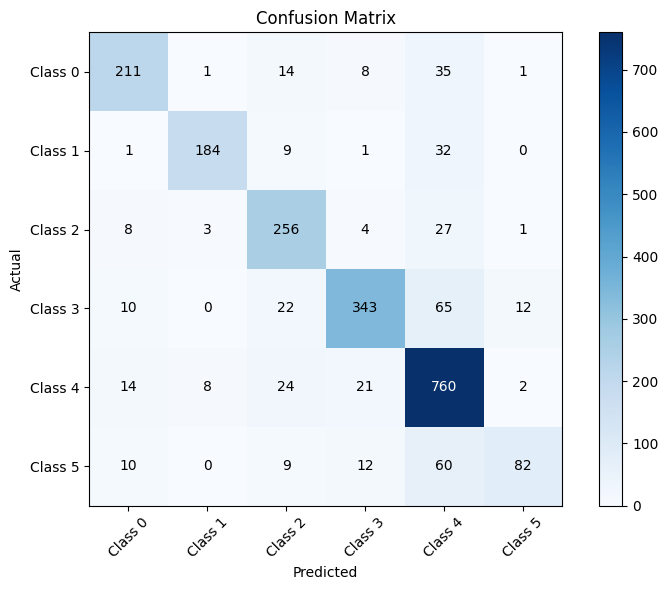

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model1 = model1.to(device)
model1.eval()
all_labels = []
all_predictions = []

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

evaluate_task(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(6)])

In [28]:
model2 = MobileNetV3()
model2.load_state_dict(torch.load(r'C:\Users\Nickv\Documents\ImageProcessing\Project\models\model2\model2_epoch_50.pth'))
model2.eval()

c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nickv\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (mobilenet_v3): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(



Classification Report:
               precision    recall  f1-score   support

     Class 0       0.80      0.97      0.88       270
     Class 1       0.92      0.90      0.91       227
     Class 2       0.95      0.82      0.88       299
     Class 3       0.89      0.84      0.87       452
     Class 4       0.90      0.93      0.92       829
     Class 5       0.90      0.82      0.86       173

    accuracy                           0.89      2250
   macro avg       0.89      0.88      0.89      2250
weighted avg       0.90      0.89      0.89      2250



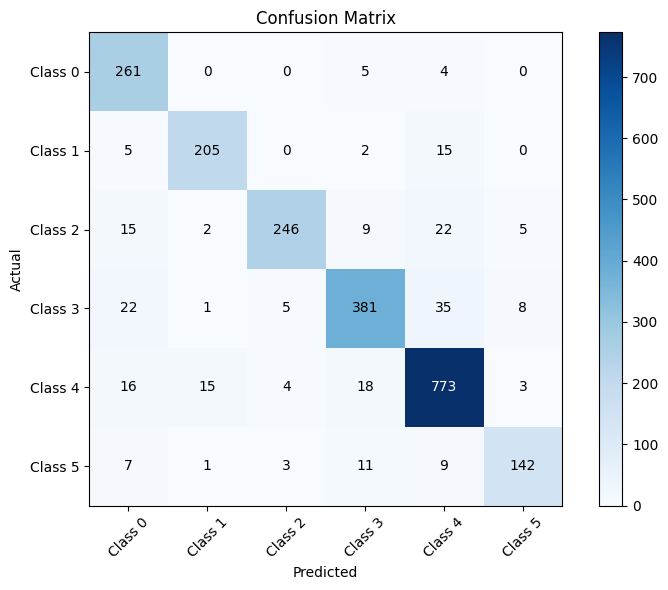

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model2 = model2.to(device)
model2.eval()
all_labels = []
all_predictions = []

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model2(images)
        _, predicted = torch.max(outputs, 1)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

evaluate_task(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(6)])